In [1]:
from mofgraph2vec.data.datamodule import DataModuleFactory
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle
import matplotlib as mpl
import pandas as pd
import json
import sklearn
mpl.rcParams["font.size"] = 16

In [2]:
df = pd.read_csv("../data/arc-core-xq-1120.csv")
for key in df.keys():
    if "xq" in key:
        print(key)

xq.ch4_kh
xq.ch4_kh_dev
xq.ch4_uptake_580000
xq.ch4_uptake_580000_dev
xq.ch4_uptake_6500000
xq.ch4_uptake_6500000_dev
xq.ch4_logkh
xq.co2_kh
xq.co2_kh_dev
xq.n2_kh
xq.n2_kh_dev
xq.co2_n2_wc
xq.ch4_wc
xq.co2_n2_selectivity


/var/folders/gt/tsyp2wjd1ng0pkr1tf52kn600000gn/T/ipykernel_86311/314213715.py:1: DtypeWarning: Columns (22,25,106,107,108,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/arc-core-xq-1120.csv")


In [3]:
df_sub = df[df["xq.co2_n2_selectivity"]< 200]

In [5]:
df_sub.to_csv("../data/arc-core-xq-1120-sub.csv", index=False)

In [4]:
def get_numpy_regression_metrics(target, pred):
    metrics = {}
    metrics["MSE"] = '%.3f' %sklearn.metrics.mean_squared_error(pred, target)
    metrics["MAE"] = '%.3f' %sklearn.metrics.mean_absolute_error(pred, target)
    metrics[f"$R^2$"] = '%.3f' %sklearn.metrics.r2_score(target, pred)
    return metrics

In [7]:
# Regression model path
post_wc_path = "offline-run-20231120_113823-ghpfba5g"
post_sel_path = "offline-run-20231120_134307-9u0xyhfb"

natpur_wc_path = "offline-run-20231120_120812-2fc76bnn" # 0.89/0.61
natpur_sel_path = "offline-run-20231120_121342-gt72qigz"

In [5]:
# Regression model path
ch4_kh_path = "offline-run-20231120_135801-qh4tlc1e" 
ch4_wc_path = "offline-run-20231120_140147-57p21rfp"

co2_n2_sel_path = "offline-run-20240408_181938-b6wdncq3"
co2_n2_wc_path = "offline-run-20231120_140849-skazctfq"

In [6]:
train_trues = []
train_preds = []
test_trues = []
test_preds = []

# for outpath in [post_wc_path, post_sel_path, natpur_wc_path, natpur_sel_path]:
for outpath in [ch4_kh_path, ch4_wc_path, co2_n2_sel_path, co2_n2_wc_path]:
    with open('../experiments/workflow/wandb/%s/tmp/prediction.json' %outpath, 'r') as fp:
        data = json.load(fp)
    data = json.loads(data)
    
    data_train = data['train']
    data_test = data['test']

    train_true = [x[0] for x in data_train]
    train_pred = [x[1] for x in data_train]

    test_true = [x[0] for x in data_test]
    test_pred = [x[1] for x in data_test]
    
    train_trues.append(train_true)
    train_preds.append(train_pred)
    test_trues.append(test_true)
    test_preds.append(test_pred)

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/workflow/wandb/offline-run-20240408_181938-b6wdncq3/tmp/prediction.json'

In [10]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

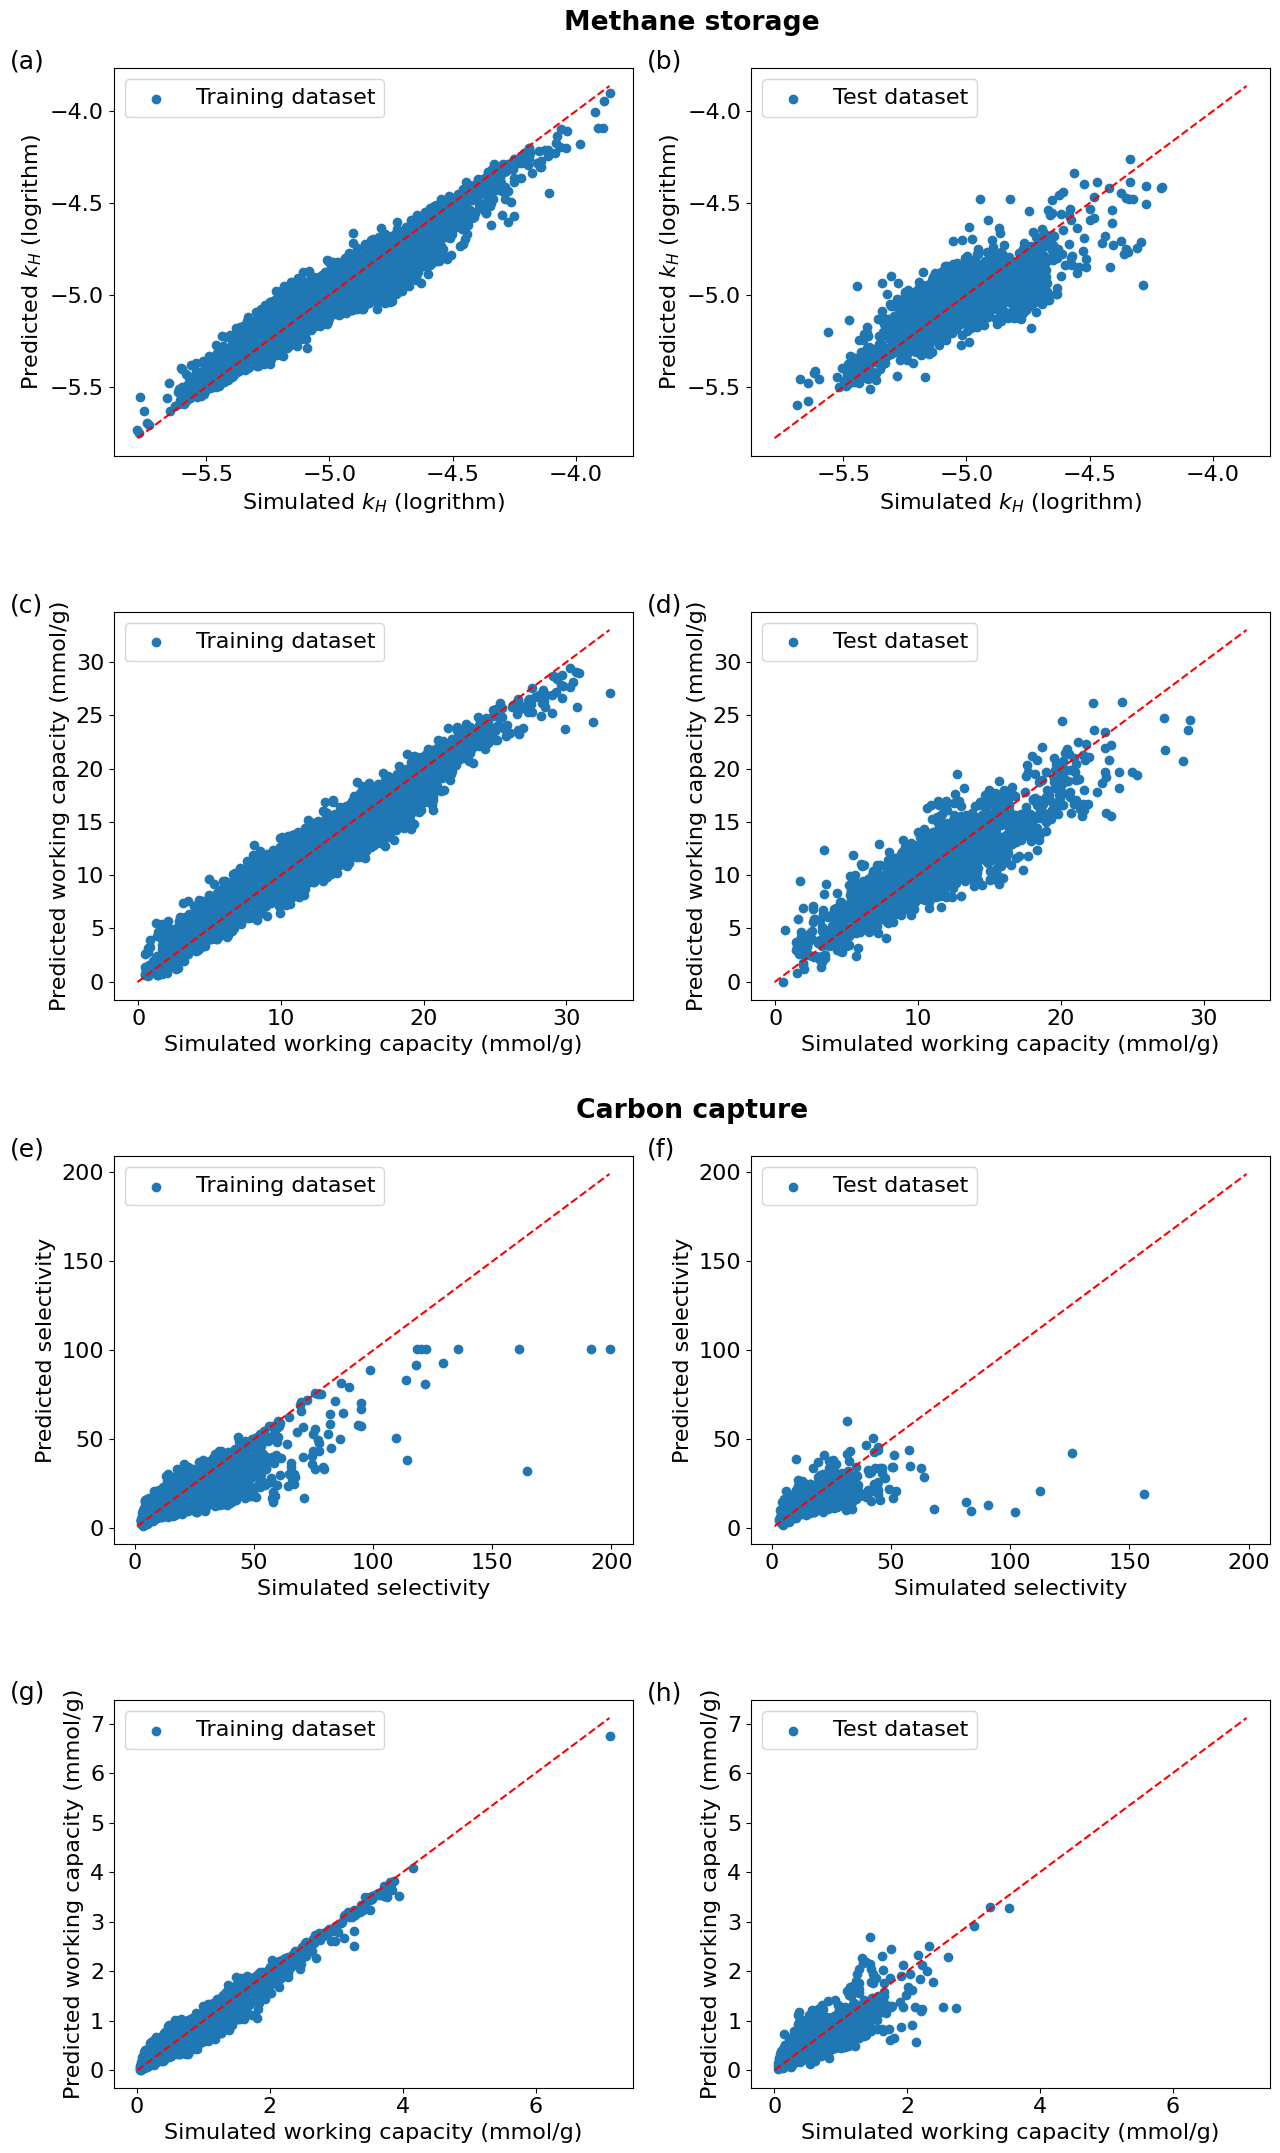

In [12]:
fig, ax = plt.subplots(4,2)
fig.set_size_inches(13,22)

i = 0
# tasknames = ["working capacity (mmol/g)", "selectivity", "working capacity (mmol/g)", "selectivity"]
tasknames = ["$k_H$ (logrithm)", "working capacity (mmol/g)", "selectivity", "working capacity (mmol/g)"]
for train_true, train_pred, test_true, test_pred in zip(train_trues, train_preds, test_trues, test_preds):
    min = np.min(np.concatenate((train_pred, test_pred, train_true, test_true)))
    max = np.max(np.concatenate((train_pred, test_pred, train_true, test_true)))

    ax[i,0].plot([min, max], [min, max], 'r--')
    ax[i,1].plot([min, max], [min, max], 'r--')
    ax[i,0].scatter(train_true, train_pred, label="Training dataset")
    # ax[i,0].text(max-abs(0.25*max), min, json.dumps(get_numpy_regression_metrics(train_true, train_pred), indent=4), fontdict={'fontsize': 10.5})
    ax[i,1].scatter(test_true, test_pred, label="Test dataset")
    # ax[i,1].text(max-abs(0.25*max), min, json.dumps(get_numpy_regression_metrics(test_true, test_pred), indent=4), fontdict={'fontsize': 10.5})

    ax[i,0].set_xlabel("Simulated %s" %tasknames[i])
    ax[i,1].set_xlabel("Simulated %s" %tasknames[i])
    ax[i,0].set_ylabel("Predicted %s" %tasknames[i])
    ax[i,1].set_ylabel("Predicted %s" %tasknames[i])
    i += 1
    
for i, axs in enumerate(ax.flat):
    axs.text(-0.2, 1.0, f'({chr(97 + i)})', transform=axs.transAxes, size=18) 
    axs.legend()

grid = plt.GridSpec(4, 2)
create_subtitle(fig, grid[0, ::], 'Methane storage')
create_subtitle(fig, grid[2, ::], 'Carbon capture')

fig.tight_layout()
fig.savefig("../../../files/figures_oct23/SI-parityplot_v21.02.24.png", dpi=300)

In [13]:
for train_true, train_pred, test_true, test_pred in zip(train_trues, train_preds, test_trues, test_preds):
    print(f"Train: {get_numpy_regression_metrics(train_true, train_pred)}")
    print(f"Test: {get_numpy_regression_metrics(test_true, test_pred)}")

Train: {'MSE': '0.004', 'MAE': '0.050', '$R^2$': '0.890'}
Test: {'MSE': '0.016', 'MAE': '0.099', '$R^2$': '0.598'}
Train: {'MSE': '1.019', 'MAE': '0.775', '$R^2$': '0.934'}
Test: {'MSE': '3.655', 'MAE': '1.484', '$R^2$': '0.763'}
Train: {'MSE': '20.620', 'MAE': '2.814', '$R^2$': '0.706'}
Test: {'MSE': '54.236', 'MAE': '3.789', '$R^2$': '0.351'}
Train: {'MSE': '0.012', 'MAE': '0.083', '$R^2$': '0.919'}
Test: {'MSE': '0.051', 'MAE': '0.164', '$R^2$': '0.620'}
